# Exploratory data analysis

## TOC:
* [Exploring the metadata](#first-bullet)
* [Exploring visuall x-rays](#second-bullet)

In [1]:
# execute this cell only once to change the current directory

from pathlib import Path
import os

root_dir = Path(os.getcwd()).parents[0]
os.chdir(root_dir)
print(f'WORKDIR: {root_dir}')

WORKDIR: /ml_codes


In [2]:
import pandas as pd 
import numpy as np 
import seaborn as sns #visualisation
import matplotlib.pyplot as plt #visualisation
%matplotlib inline 
sns.set(color_codes=True) 

In [3]:
df = pd.read_csv('data/train_labels.csv')
df.dtypes

view          object
sex           object
age            int64
monochrome    object
sop           object
series        object
study         object
filename      object
height         int64
width          int64
ImageId       object
ptx_binary     int64
mask_size      int64
dtype: object

## Exploring the metadata <a class="anchor" id="first-bullet"></a>

Distribution of positive (1) and negative (0) cases

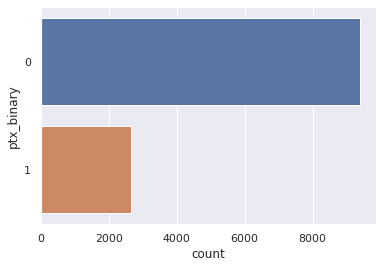

In [4]:
ax = sns.countplot(y="ptx_binary", data=df)

Distribution of positive (1) and negative (0) cases discriminating Female or Male

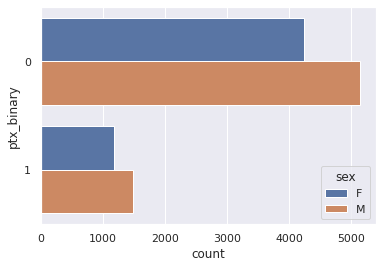

In [5]:
ax = sns.countplot(y="ptx_binary", hue="sex", data=df)

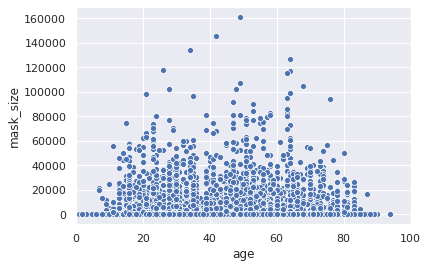

In [6]:
ax = sns.scatterplot(x='age', y='mask_size',data=df)
ax = plt.xlim(0,100)

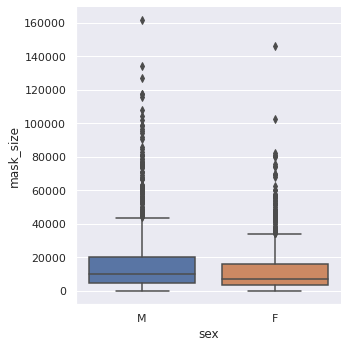

In [7]:
# Mask size boxplot 
sns.catplot(x="sex", y="mask_size", kind = "box", data=df[df.ptx_binary==1])

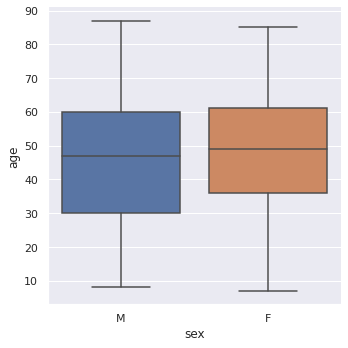

In [8]:
# Mask size boxplot 
sns.catplot(x="sex", y="age", kind = "box", data=df[df.ptx_binary==1])

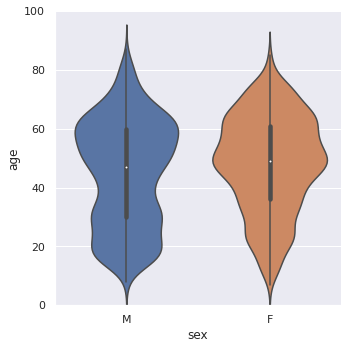

In [9]:
ax = sns.catplot(x="sex", y="age", kind = "violin", data=df[df.ptx_binary==1])
ax = plt.ylim(0,100)

## Exploring visually x-rays <a class="anchor" id="second-bullet"></a>

In [17]:
from mpl_toolkits.axes_grid1 import ImageGrid
import cv2

In [40]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [71]:
def visualize_list(images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        #plt.title(' '.join(name.split('_')).title())
        plt.imshow(images[i])
    plt.show()

### Plot male/female images non-pneumothorax

In [129]:
def get_images(df):
    # list of image paths
    images_dir_train = 'data/pngs/train'
    images_ids = df.ImageId.tolist()
    images_path = [os.path.join(images_dir_train,image_id) + '.png' for image_id in images_ids]
    #list with images
    images = [cv2.imread(image_path, 1) for image_path in images_path]
    return images

In [133]:
df_male_non_pneumo_sample =  df[(df.sex == 'M') & (df.ptx_binary == 0)].sample(n=5)
df_female_non_pneumo_sample =  df[(df.sex == 'F') & (df.ptx_binary == 0)].sample(n=5)

In [134]:
male_images = get_images(df_male_non_pneumo_sample)
female_images = get_images(df_female_non_pneumo_sample)

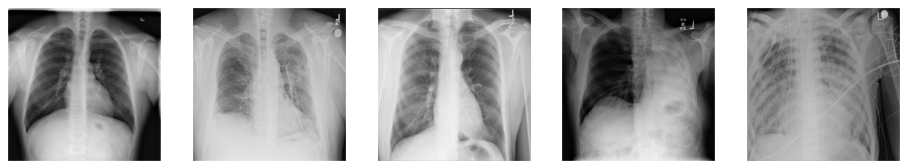

In [131]:
visualize_list(male_images)

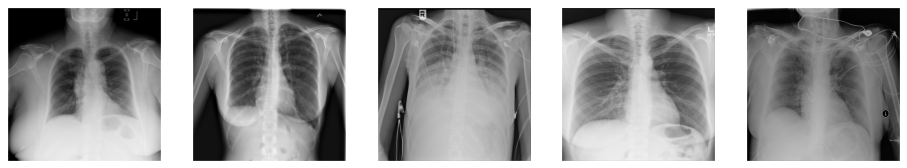

In [135]:
visualize_list(female_images)

### Plot male/female images with pneumothorax

In [122]:
def compute_colored_masked_image_arr(image,masks,colors,alpha=0.5):
    """Compute an overlapping image using the colored masks (masks as array)
    """
    masked_image = image.astype(np.uint8).copy()
    # Single mask
    if len(masks.shape)==2:
        color = colors[0]
        mask = masks[:,:]
        masked_image = apply_mask(masked_image, mask, color, alpha=alpha)
        
    # Multiple channels - Multiple masks    
    else:    
        N = masks.shape[-1]
        for idx in range(N):
            color = colors[idx]
            mask = masks[:,:,idx]
            masked_image = apply_mask(masked_image, mask, color, alpha=alpha)

    return masked_image

In [97]:
def apply_mask(image, mask, color, alpha=0.5):
    """Overlaps a colored mask over a RGB image

    Args:
        image: target RGB image
        mask: boolean mask 
        color: RGB mask color for visualization
        alpha: mask oppacity for visualization
    Return:
        RGB image with the colored mask 
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c],
                                  image[:, :, c])
    return image

In [149]:
def get_masked_images(df):
    # list of image paths
    images_dir_train = 'data/pngs/train'
    masks_dir_train = 'data/masks_255/train'
    images_ids = df.ImageId.tolist()
    images_path = [os.path.join(images_dir_train,image_id) + '.png' for image_id in images_ids]
    masks_path = [os.path.join(masks_dir_train,image_id) + '.png' for image_id in images_ids]
    
    #list with images
    images = [cv2.imread(image_path, 1) for image_path in images_path] # 3 channels
    masks = [(cv2.imread(mask_path, 0)/255) for mask_path in masks_path]
    
    # Single mask color
    colors = [[255,0,0]]
    
    masked_images = [compute_colored_masked_image_arr(images[i],masks[i],colors=colors,alpha=0.3) for i in range(len(images))]
    return masked_images

In [150]:
df_male_pneumo_sample =  df[(df.sex == 'M') & (df.ptx_binary == 1)].sample(n=5)
df_female_pneumo_sample =  df[(df.sex == 'F') & (df.ptx_binary == 1)].sample(n=5)

In [151]:
male_masked_images = get_masked_images(df_male_pneumo_sample)
female_masked_images = get_masked_images(df_female_pneumo_sample)

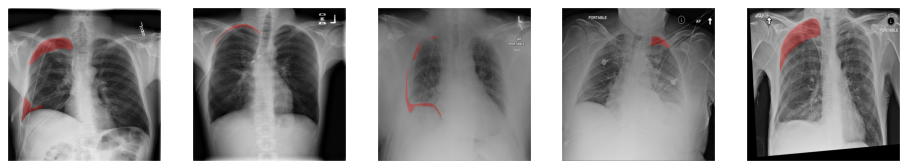

In [152]:
visualize_list(male_masked_images)

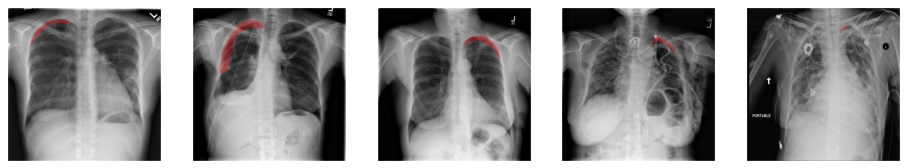

In [153]:
visualize_list(female_masked_images)